<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Детекция объектов</b></h3>

В этом домашнем задании мы продолжим работу над детектором из семинара, поэтому при необходимости можете заимствовать оттуда любой код.

Домашнее задание можно разделить на следующие части:

* Переделываем модель [4]
  * Backbone[1],
  * Neck [2],
  * Head [1]
* Label assignment [3]:
  * TAL [3]
* Лоссы [1]:
  * CIoU loss [1]
* Кто больше? [5]
  * 0.05 mAP [1]
  * 0.1 mAP  [2]
  * 0.2 mAP [5]

**Максимальный балл:** 10 баллов. (+3 балла бонус).

In [172]:
from PIL import Image
import io
import numpy as np
import pandas as pd
from functools import partial

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision.ops import box_iou, nms
from torchvision import transforms

from torchmetrics.detection.mean_ap import MeanAveragePrecision

from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

### Загрузка данных

Мы продолжаем работу с датасетом из семинара - Halo infinite ([сслыка](https://universe.roboflow.com/graham-doerksen/halo-infinite-angel-aim)). Загрузка данных и создание датасета полностью скопированы из семинара.

Сначала загружаем данные

In [173]:
from datasets import load_dataset

ds = load_dataset("Francesco/halo-infinite-angel-videogame")
df_train = ds["train"].to_pandas()
df_val = ds["validation"].to_pandas()
df_test = ds["test"].to_pandas()

In [174]:
df_train.head(1)

,image_id,image,width,height,objects
0,311,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,640,640,"{'id': [573, 574], 'area': [1748, 15756], 'bbo..."


In [175]:
pd.json_normalize(df_train["image"]).head(1)

,bytes,path
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,pic_21_12_25_1610_53-0_png_jpg.rf.a8f692edfcd1...


In [176]:
pd.json_normalize(df_train["objects"]).head(1)

,id,area,bbox,category
0,"[573, 574]","[1748, 15756]","[[248.0, 228.0, 38.0, 46.0], [232.0, 228.0, 78...","[2, 1]"


Создаем датасет для предобработки данных

In [177]:
# Определяем константы для цвета и названий классов
class_to_color = {
    1: (89, 161, 197),
    2: (204, 79, 135),
    3: (125, 216, 93),
    4: (175, 203, 33),
}

class_to_name = {
    1 : "enemy",
    2 : "enemy-head",
    3 : "friendly",
    4 : "friendly-head"
}

pred_class_to_color = {
    1: (245, 200, 87),
    2: (226, 133, 46),
    3: (255, 238, 145),
    4: (171, 224, 240),
}

In [178]:
import math
import cv2

# Вспомогательные функции для отрисовки данных
def add_bbox(image, box, label='', color=(128, 128, 128), txt_color=(0, 0, 0)):
    image = np.ascontiguousarray(image)

    box = np.array(box, dtype=float).reshape(-1)
    if box.size != 4:
        return image

    if not np.all(np.isfinite(box)):
        return image

    x1, y1, x2, y2 = box.tolist()

    h, w = image.shape[:2]

    x1 = np.clip(x1, 0, w - 1)
    x2 = np.clip(x2, 0, w - 1)
    y1 = np.clip(y1, 0, h - 1)
    y2 = np.clip(y2, 0, h - 1)

    if x2 <= x1 or y2 <= y1:
        return image

    lw = max(round((h + w) / 2 * 0.003), 2)

    p1 = (int(x1), int(y1))
    p2 = (int(x2), int(y2))

    cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)

    if label:
        tf = max(lw - 1, 1)
        w_txt, h_txt = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]
        outside = p1[1] - h_txt >= 3
        if outside:
            p2_label = (p1[0] + w_txt, p1[1] - h_txt - 3)
            text_org = (p1[0], p1[1] - 2)
        else:
            p2_label = (p1[0] + w_txt, p1[1] + h_txt + 3)
            text_org = (p1[0], p1[1] + h_txt + 2)

        cv2.rectangle(image, p1, p2_label, color, -1, cv2.LINE_AA)
        cv2.putText(
            image,
            label,
            text_org,
            0,
            lw / 3,
            txt_color,
            thickness=tf,
            lineType=cv2.LINE_AA,
        )
    return image

def plot_examples(df, indices=None, num_examples=6, row_figsize=(12, 3)):
    if indices is None:
        indices = np.random.choice(len(df), size=num_examples, replace=False)
    else:
        num_examples = len(indices)

    ncols = min(num_examples, 3)
    nrows = math.ceil(num_examples / 3)
    _, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(row_figsize[0], row_figsize[1] * nrows),
        tight_layout=True,
    )
    axes = axes.reshape(-1)

    for ix, ax in zip(indices, axes):
        row = df.iloc[ix]
        image = Image.open(io.BytesIO(row["image"]["bytes"]))

        bboxes_xywh = row["objects"]["bbox"]
        classes = row["objects"]["category"]

        img = np.array(image)

        for bbox, label in zip(bboxes_xywh, classes):
            x, y, w, h = bbox
            bbox_xyxy = [x, y, x + w, y + h]

            color = class_to_color.get(label, (128, 128, 128))
            class_name = class_to_name.get(label, str(label))
            img = add_bbox(img, bbox_xyxy, label=str(class_name), color=color)

        ax.imshow(img)
        ax.set_title(f"Image id: {row['image_id']}")
        ax.set_xticks([])
        ax.set_yticks([])

    for ax in axes[num_examples:]:
        ax.axis("off")

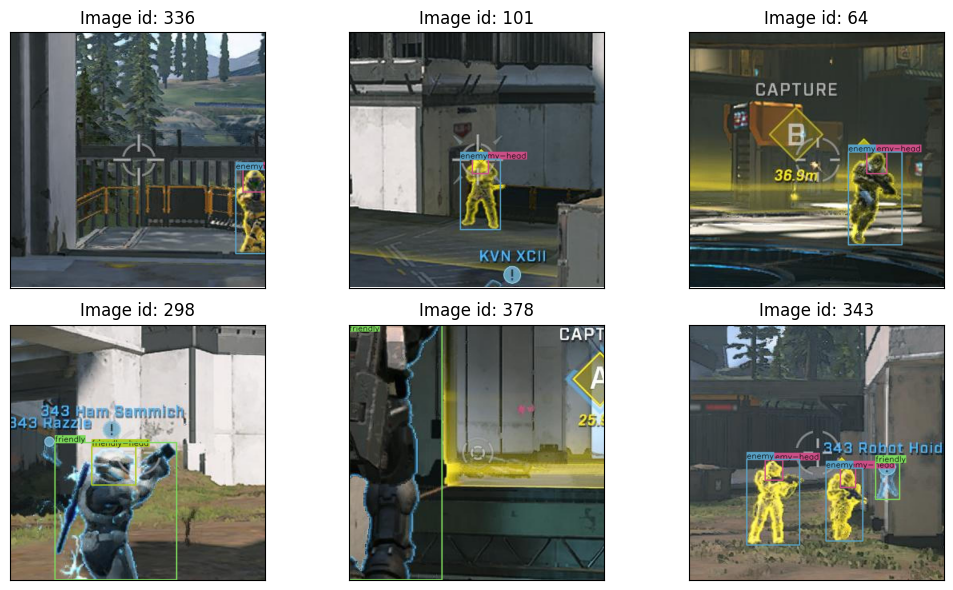

In [179]:
plot_examples(df_train)

In [180]:
# Вспомогательные функции для обработки данных
def safe_logit(x):
    eps = 1e-6
    x = torch.clamp(x, eps, 1 - eps)
    return torch.log(x / (1 - x))


def xywh_to_xyxy_np(boxes):
    boxes = np.asarray(boxes, dtype=np.float32)
    if boxes.ndim == 1:
        x, y, w, h = boxes
        return np.array([x, y, x + w, y + h], dtype=np.float32)
    x = boxes[:, 0]
    y = boxes[:, 1]
    w = boxes[:, 2]
    h = boxes[:, 3]
    x2 = x + w
    y2 = y + h
    return np.stack([x, y, x2, y2], axis=-1)


def xywh_to_xyxy(boxes):
    x, y, w, h = boxes.unbind(-1)
    x2 = x + w
    y2 = y + h
    return torch.stack([x, y, x2, y2], dim=-1)

In [181]:
class HaloDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        df_objects = pd.json_normalize(dataframe["objects"])[["bbox", "category"]]
        df_images = pd.json_normalize(dataframe["image"])[["bytes"]]
        self.data = dataframe[["image_id"]].join(df_objects).join(df_images)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = Image.open(io.BytesIO(row["bytes"]))
        image = np.array(image)

        target = {}
        target["image_id"] = row["image_id"]

        labels = [row["category"]] if isinstance(row["category"], int) else row["category"]
        # вычитаем единицу, чтобы классы начинались с нуля
        labels = [label - 1 for label in labels]

        boxes = row["bbox"]
        if isinstance(boxes, np.ndarray):
            boxes = boxes.tolist()
        if boxes and isinstance(boxes[0], (int, float, np.number)):
            boxes = [boxes]

        boxes_xyxy = [xywh_to_xyxy_np(b) for b in boxes]

        if self.transform is not None:
            transformed = self.transform(image=image, bboxes=boxes_xyxy, labels=labels)
            image = transformed["image"]
            boxes_xyxy = transformed["bboxes"]
            labels = transformed["labels"]
        else:
            image = transforms.ToTensor()(image)

        target["boxes"] = torch.tensor(np.array(boxes_xyxy), dtype=torch.float32)
        target["labels"] = torch.tensor(labels, dtype=torch.int64)
        return image, target


def collate_fn(batch):
    batch = tuple(zip(*batch))
    images = torch.stack(batch[0])
    return images, batch[1]

Чтобы модель не переобучалась, можно добавить больше аугментаций, весь список можно посмотреть тут [[ссылка](https://explore.albumentations.ai/)].

Какие можно использовать аугментации?
* Добавить зум `RandomResizedCrop`,
* Сделать цветовые аугментации типа `RandomBrightnessContrast` и/или `HueSaturationValue`,
* Добавить шум `GaussNoise`,
* Вырезать случайные части изображения `CoarseDropout`,
* И любые другие!

Аугментации можно комбинировать посредствам `A.OneOf`, `A.SomeOf` или `A.RandomOrder`.

Хоть аугментации ограничиваются только вашей фантазией, перед обучением советуем посмотреть на результат преобразований и убедиться, что изображение ещё поддается детекции:)

In [182]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        # Добавляй сюда свои аугментации при необходимости!
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    # Раскомментируй, если аугментации изменяют ббоксы.
    # Не забудь указать верный формат для ббоксов.
    # bbox_params=A.BboxParams(format='coco', label_fields=['labels'])
)

test_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

Не забываем инициализировать наш датасет

In [183]:
train_dataset = HaloDataset(df_train, transform=train_transform)
test_dataset = HaloDataset(df_test, transform=test_transform)

## Переделываем модель [4 балла]

В семинаре мы реализовали самый базовый детектор, а сейчас настало время его улучшать.

### Backbone [1 балл]

Хорошей практикой считается размораживать несколько последних слоев в backbone, это позволяет немного улучить качество модели. Давайте улушчим класс Backbone из лекции, добавив ему возможность разморозки __k__ последних слоев или блоков (на ваш выбор).

In [184]:
class Backbone(nn.Module):
    def __init__(self, model_name="efficientnet_b0", out_indices=(-3, -2, -1), unfreeze_last=2):
        super().__init__()
        # timm.list_models(pretrained=True)
        self.backbone = timm.create_model(model_name, pretrained=True, features_only=True, out_indices=out_indices)
        # Выключаем градиенты у модели, чтобы упростить обучение
        params = list(self.backbone.parameters())
        if unfreeze_last > 0:
            for p in params[:-unfreeze_last]:
                p.requires_grad = False
        else:
            for p in params:
                p.requires_grad = False

    def forward(self, x):
        return self.backbone(x)

### NECK [2 балла]

Следующее улучшение коснется шеи. Предлагаем реализовать знакомую из лекции архитектуру FPN.

#### Feature Pyramid Network

<center><img src="https://user-images.githubusercontent.com/57972646/69858594-b14a6c00-12d5-11ea-8c3e-3c17063110d3.png"/></center>


* [Feature Pyramid Networks for Object Detection](https://arxiv.org/abs/1612.03144)

Она состоит из top-down пути, в котором происходит 2 вещи:
1. Увеличивается пространственная размерность фичей,
2. С помощью скипконнекшеннов, добавляются фичи из backbone модели.

Для увеличения пространственной размерности используется __nearest neighbor upsampling__, а фичи из шеи и бекбоуна суммируются.

__TIPS__:
* Можете использовать базовые классы из лекции,
* Воспользуйтесь AnchorGenerator-ом, чтобы создавать якоря сразу для нескольких выходов,
* Не забудьте использовать nn.ModuleList, если захотите сделать динамическое количество голов у модели,
* Также, можно добавить доп конволюцию (3х3 с паддингом) у каждого выхода шеи.

In [185]:
class Neck(nn.Module):
    # Feature Pyramid Network
    def __init__(self, in_channels_list, out_channels, use_activations=True):
        super().__init__()
        self.out_channels = out_channels

        in0, in1, in2 = in_channels_list
        # 1x1 свертки - приводим каналы к out_channels
        self.conv10 = nn.Conv2d(in0, out_channels, kernel_size=1)
        self.conv11 = nn.Conv2d(in1, out_channels, kernel_size=1)
        self.conv12 = nn.Conv2d(in2, out_channels, kernel_size=1)
        # 3x3 свертки - финальная обработка на каждом уровне пирамиды
        self.conv30 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.conv31 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.conv32 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.bn0 = nn.BatchNorm2d(out_channels)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.activation = nn.ReLU(inplace=True) if use_activations else nn.Identity()

    def forward(self, features):
        f0, f1, f2 = features # f0 - самый верхний, f2 - самый глубокий

        inner0 = self.conv10(f0)
        p0 = self.activation(self.bn0(self.conv30(inner0)))

        inner1 = self.conv11(f1)
        up0 = F.interpolate(inner0, size=inner1.shape[-2:], mode="nearest")
        inner1 = inner1 + up0
        p1 = self.activation(self.bn1(self.conv31(inner1)))

        inner2 = self.conv12(f2)
        up1 = F.interpolate(inner1, size=inner2.shape[-2:], mode="nearest")
        inner2 = inner2 + up1
        p2 = self.activation(self.bn2(self.conv32(inner2)))

        return [p0, p1, p2]

### Head [1 балл]

В качестве головы можно выбрать __один из двух__ вариантов:

#### 1. Decoupled Head

Реализовать Decoupled Head из [YOLOX](https://arxiv.org/abs/2107.08430).
<center><img src="https://i.ibb.co/BVtBR2R3/Decoupled-head.jpg"/></center>

**TIP**: Возьмите за основу голову из семинара, тк она сильно похожа на Decoupled Head.

Изменять количество параметров у шей на разных уровнях не обязательно.

#### 2. Confidence score free head

Нужно взять за основу голову из семинара и полностью убрать предсказание confidence score. Чтобы модель предсказывала только 2 группы: ббоксы и классы.

Есть следующие способы удаления confidence score:
* Добавление нового класса ФОН. Обычно его обозначают нулевым классом.
* Присваивание ббоксам БЕЗ объекта вектор из нулей в качестве таргета.

Выберете тот, который вам больше нравится и будте внимательны при расчете лосса!

**Важно!** Удаление confidence score повлияет на следующие методы из семинара:
* target_assign
* ComputeLoss
* _filter_predictions

In [186]:
class Head(nn.Module):
    def __init__(self, in_channels, num_classes, num_anchors):
        super().__init__()
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        # адаптация фич от шеи
        self.reduce = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        # классификация
        self.cls0 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.cls1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.cls_head = nn.Conv2d(in_channels, num_anchors * num_classes, kernel_size=1)
        # регрессия
        self.bbox0 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bbox1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bbox_head = nn.Conv2d(in_channels, num_anchors * 4, kernel_size=1)

    def forward(self, features):
        all_cls = []
        all_bbox = []

        for f in features:
            x = self.reduce(f)
            # классификация
            c = F.relu(self.cls0(x))
            c = F.relu(self.cls1(c))
            cls_logits = self.cls_head(c)
            # регрессия
            r = F.relu(self.bbox0(x))
            r = F.relu(self.bbox1(r))
            bbox_pred = self.bbox_head(r)

            all_cls.append(cls_logits)
            all_bbox.append(bbox_pred)

        return all_cls, all_bbox

Теперь можно снова реализовать класс детектора с учетом всех частей выше!

In [187]:
import timm
from torchvision.models.detection.anchor_utils import AnchorGenerator

class Detector(nn.Module):
    def __init__(
        self,
        backbone_model_name="efficientnet_b0",
        neck_n_channels=256,
        num_classes=5,
        anchor_sizes=(32, 64, 128),
        anchor_ratios=(0.5, 1.0, 2.0),
        input_size=(640, 640),
        out_indices=(-3, -2, -1),
        unfreeze_last=2,
    ):
        super().__init__()

        self.num_classes = num_classes
        
        self.backbone = Backbone(
            model_name=backbone_model_name,
            out_indices=out_indices,
            unfreeze_last=unfreeze_last,
        )

        in_channels_list = self.backbone.backbone.feature_info.channels()
        self.neck = Neck(in_channels_list, out_channels=neck_n_channels)

        num_anchors = len(anchor_sizes) * len(anchor_ratios)
        self.num_anchors = num_anchors
        self.head = Head(
            in_channels=self.neck.out_channels,
            num_classes=num_classes,
            num_anchors=num_anchors,
        )

        self._init_anchors(anchor_sizes, anchor_ratios, input_size)

    def _init_anchors(self, anchor_sizes, anchor_ratios, input_size):
        num_feature_maps = len(self.backbone.backbone.feature_info.channels())

        sizes = (anchor_sizes,) * num_feature_maps
        aspect_ratios = (anchor_ratios,) * num_feature_maps
        anchor_generator = AnchorGenerator(sizes=sizes, aspect_ratios=aspect_ratios)

        reductions = self.backbone.backbone.feature_info.reduction()
        grid_sizes = [
            [input_size[0] // r, input_size[1] // r] for r in reductions
        ]
        strides = [[r, r] for r in reductions]

        anchors_per_level = anchor_generator.grid_anchors(
            grid_sizes,
            strides=strides,
        )

        anchors = torch.cat(anchors_per_level, dim=0)
        anchors = anchors.unsqueeze(0)

        anchor_centers = (anchors[:, :, :2] + anchors[:, :, 2:]) / 2
        anchor_sizes_t = (anchors[:, :, 2:] - anchors[:, :, :2])

        self.register_buffer("anchors", anchors)
        self.register_buffer("anchor_centers", anchor_centers)
        self.register_buffer("anchor_sizes", anchor_sizes_t)

    def forward(self, x):
        B = x.shape[0]

        features = self.backbone(x)
        neck_features = self.neck(features)
        all_cls, all_bbox = self.head(neck_features)
        
        cls_list = []
        bbox_list = []
        for cls_logits_level, bbox_level in zip(all_cls, all_bbox):
            cls_logits_level = cls_logits_level.permute(0, 2, 3, 1).contiguous()
            cls_logits_level = cls_logits_level.view(B, -1, self.num_classes)
            cls_list.append(cls_logits_level)

            bbox_level = bbox_level.permute(0, 2, 3, 1).contiguous()
            bbox_level = bbox_level.view(B, -1, 4)
            bbox_list.append(bbox_level)

        cls_logits = torch.cat(cls_list, dim=1)
        bbox_offsets = torch.cat(bbox_list, dim=1)

        if self.training:
            return bbox_offsets, cls_logits

        # инференс
        # bboxes = self.decode_bboxes(bbox_offsets)
        # cls_probs = torch.softmax(cls_logits, dim=-1)
        return bbox_offsets, cls_logits

    def decode_bboxes(self, bbox_offsets):
        device = bbox_offsets.device
    
        tx = bbox_offsets[:, :, 0]
        ty = bbox_offsets[:, :, 1]
        tw = bbox_offsets[:, :, 2]
        th = bbox_offsets[:, :, 3]
    
        anchor_centers = self.anchor_centers.to(device)
        anchor_sizes = self.anchor_sizes.to(device)
    
        center_x = anchor_centers[:, :, 0] + torch.sigmoid(tx) * anchor_sizes[:, :, 0]
        center_y = anchor_centers[:, :, 1] + torch.sigmoid(ty) * anchor_sizes[:, :, 1]
    
        w = torch.exp(tw) * anchor_sizes[:, :, 0]
        h = torch.exp(th) * anchor_sizes[:, :, 1]
    
        x_min = center_x - w / 2
        y_min = center_y - h / 2
        x_max = center_x + w / 2
        y_max = center_y + h / 2
    
        return torch.stack([x_min, y_min, x_max, y_max], dim=-1)

## Label assignment [3 балла]
В этой секции предлагается заменить функцию `assign_target` на более современный алгоритм который называется Task alignment learning.

Он описан в статье [TOOD](https://arxiv.org/abs/2108.07755) в секции 3.2. Для удобства вот его основные шаги:

1. Посчитать значение метрики для каждого предсказанного ббокса:
    
$$t = s^\alpha * u^\beta$$
    
где,
* $s$ — classification score, или вероятность принадлежности предсказанного ббокса к классу реального ббокса (**GT**);
* $u$ — IoU между предсказанным и реальным ббоксами;
* $\alpha,\ \beta$ — нормализационные константы, обычно $\alpha = 6.0, \ \beta = 1.0$.
    
2. Отфильтровать предсказания на основе **GT**.

    Для якорных детекторов, обычно, выбираются только те предсказания, центры якорей которых находятся внутри GT.
4. Для каждого **GT** выбрать несколько (обычно 5 или 13) самых подходящих предсказаний.
5. Если предсказание рассматривается в качестве подходящего для нескольких **GT** — выбрать **GT** с наибольшим пересечением по IoU.


**BAЖНО**: если будете использовать Runner из лекции, не забудьте поменять параметры  в `self.assign_target_method` в методе `_run_train_epoch`.

In [188]:
def TAL_assigner(
    anchors,
    bbox_offsets,
    cls_logits,
    gt_boxes,
    gt_labels,
    num_classes,
    alpha = 6.0,
    beta = 1.0,
    top_k = 13,
):
    device = anchors.device
    N = anchors.shape[0]

    target_offsets = torch.zeros((N, 4), device=device)
    target_cls = torch.zeros(N, dtype=torch.long, device=device)
    fg_mask = torch.zeros(N, dtype=torch.bool, device=device)

    if gt_boxes.numel() == 0:
        return target_offsets, target_cls, fg_mask

    gt_xyxy = gt_boxes.to(device)
    M = gt_xyxy.shape[0]

    pred_xyxy = decode_boxes_from_offsets(bbox_offsets, anchors)
    ious = box_iou(pred_xyxy, gt_xyxy)

    cls_probs = cls_logits.softmax(dim=-1)
    probs_s = cls_probs[:, gt_labels]

    anchor_centers = (anchors[:, :2] + anchors[:, 2:]) / 2.0
    cx = anchor_centers[:, 0].unsqueeze(1)
    cy = anchor_centers[:, 1].unsqueeze(1)
    x1 = gt_xyxy[:, 0].unsqueeze(0)
    y1 = gt_xyxy[:, 1].unsqueeze(0)
    x2 = gt_xyxy[:, 2].unsqueeze(0)
    y2 = gt_xyxy[:, 3].unsqueeze(0)

    is_in_gt = (cx >= x1) & (cx <= x2) & (cy >= y1) & (cy <= y2)

    t = (probs_s ** alpha) * (ious ** beta)
    t[~is_in_gt] = -1.0

    assigned_gt_inds = torch.full((N,), -1, dtype=torch.long, device=device)
    assigned_ious = torch.zeros(N, device=device)

    for j in range(M):
        t_j = t[:, j]
        topk_vals, topk_idx = t_j.topk(k=min(top_k, N), largest=True)
        mask_pos = topk_vals > 0
        if not mask_pos.any():
            continue
        topk_idx = topk_idx[mask_pos]

        ious_j = ious[topk_idx, j]
        prev_ious = assigned_ious[topk_idx]
        better = ious_j > prev_ious

        update_idx = topk_idx[better]
        assigned_gt_inds[update_idx] = j
        assigned_ious[update_idx] = ious_j[better]

    pos_mask = assigned_gt_inds >= 0
    if not pos_mask.any():
        return target_offsets, target_cls, fg_mask

    pos_idx = pos_mask.nonzero(as_tuple=False).squeeze(1)
    gt_idx = assigned_gt_inds[pos_idx]

    target_cls[pos_idx] = gt_labels[gt_idx]
    fg_mask[pos_idx] = True

    for a_i, g_i in zip(pos_idx, gt_idx):
        anchor_box = anchors[a_i]
        gt_box_xyxy = gt_xyxy[g_i]
        target_offsets[a_i] = get_target_offset(anchor_box, gt_box_xyxy)

    return target_offsets, target_cls, fg_mask

def decode_boxes_from_offsets(offsets, anchors):
    device = offsets.device
    anchors = anchors.to(device)

    anchor_centers = (anchors[:, :2] + anchors[:, 2:]) / 2.0
    anchor_sizes = (anchors[:, 2:] - anchors[:, :2]).clamp(min=1e-6)

    tx = offsets[:, 0]
    ty = offsets[:, 1]
    tw = offsets[:, 2]
    th = offsets[:, 3]

    cx = anchor_centers[:, 0] + torch.sigmoid(tx) * anchor_sizes[:, 0]
    cy = anchor_centers[:, 1] + torch.sigmoid(ty) * anchor_sizes[:, 1]
    w = torch.exp(tw) * anchor_sizes[:, 0]
    h = torch.exp(th) * anchor_sizes[:, 1]

    x1 = cx - w / 2.0
    y1 = cy - h / 2.0
    x2 = cx + w / 2.0
    y2 = cy + h / 2.0

    return torch.stack([x1, y1, x2, y2], dim=-1)

def get_target_offset(anchor_box, gt_box):
    gt_center = (gt_box[:2] + gt_box[2:]) / 2.0
    gt_size = gt_box[2:] - gt_box[:2]

    anchor_center = (anchor_box[:2] + anchor_box[2:]) / 2.0
    anchor_size = anchor_box[2:] - anchor_box[:2]

    tx = (gt_center[0] - anchor_center[0]) / anchor_size[0]
    ty = (gt_center[1] - anchor_center[1]) / anchor_size[1]

    target_tx = safe_logit(tx)
    target_ty = safe_logit(ty)

    target_tw = torch.log(gt_size[0] / anchor_size[0])
    target_th = torch.log(gt_size[1] / anchor_size[1])

    return torch.stack([target_tx, target_ty, target_tw, target_th])

### DIoU [1]

Вместо SmoothL1, который используется в семинаре, реализуем лосс, основанный на пересечении ббоксов. В качестве тренировки давайте напишем Distance Intersection over Union (DIoU).

<center><img src=https://wikidocs.net/images/page/163613/Free_Fig_5.png></center>

Для его реализации разобъем задачу на части:

**1. Реализуем IoU:**

Пусть даны координаты для предсказанного ($B^p$) и истинного ($B^g$) ббоксов в формате XYXY или VOC PASCAL (левый верхний и правый нижний углы):

$B^p=(x^p_1, y^p_1, x^p_2, y^p_2)$, $B^g=(x^g_1, y^g_1, x^g_2, y^g_2)$, тогда алгоритм расчета будет следующий:

    1. Найдем площади обоих ббоксов:
$$ A^p = (x^p_2 - x^p_1) * (y^p_2 - y^p_1) $$
$$ A^g = (x^g_2 - x^g_1) * (y^g_2 - y^g_1) $$

    2. Посчитаем пересечение между ббоксами:

Тут мы предлагаем вам подумать как в общем виде можно расчитать размеры ббокса, который будет являться пересечением $B^p$ и $B^g$, а затем посчитать его площадь:

$$x^I_1 = \qquad \qquad y^I_1 = $$
$$x^I_2 = \qquad \qquad y^I_2 = $$

В общем виде, площать будет записываться следующим образом:

Если $x^I_2 > x^I_1$ & $y^I_2 > y^I_1$, тогда:

$$I = (x^I_2 - x^I_1) * (y^I_2 - y^I_1)$$

Иначе, $I = 0$.

    3. Считаем объединение ббоксов.

Мы можем посчитать эту площадь как сумму площадей двух ббоксов минус площадь пересечения (тк мы считаем её два раз в сумме площадей):

$$U = A^p + A^g - I$$

    4. Вычисляем IoU.

$$IoU = \frac{I}{U}$$

**2. Посчитаем диагональ выпуклой оболочки:**

Для расчета диагонали, сначала выпишите координаты верхнего левого и правого нижнего углов. Подумайте, чему будут равны эти координаты в общем случае?

$$x^c_1 = \qquad \qquad y^c_1 = $$
$$x^c_2 = \qquad \qquad y^c_2 = $$

Подсказка: Нарисуйте несколько вариантов пересечений предсказания и GT на бумажке, и выпишите координаты для выпуклой оболочки.

Тогда квадрат диагонали можно посчитать по формуле:

$$c^2 = (x^c_2 - x^c_1)^2 + (y^c_2 - y^c_1)^2$$

**3. Рассчитаем расстояние между цетрами ббоксов:**

Сначала находим координаты центров каждого из ббоксов (если ббоксы в формате YOLO, то и считать ничего не нужно), затем считаем Евклидово расстояние между центрами.

$d = $

Собираем все части вместе и считаем лосс по формуле:

$$ DIoU = 1 - IoU + \frac{d^2}{c^2}$$

Помните, что пар ббоксов может быть много! Возвращайте усредненное значение лосса.

In [189]:
from torchvision.ops import distance_box_iou_loss

In [190]:
def gen_bbox(num_boxes=10):
    min_corner = torch.randint(0, 100, (num_boxes, 2))
    max_corner = torch.randint(50, 150, (num_boxes, 2))

    for i in range(2):
        wrong_order = min_corner[:, i] > max_corner[:, i]
        if wrong_order.any():
            min_corner[wrong_order, i], max_corner[wrong_order, i] = max_corner[wrong_order, i], min_corner[wrong_order, i]
    return torch.cat((min_corner, max_corner), dim=1)

In [191]:
pred_boxes = gen_bbox(num_boxes=100)
true_boxes = gen_bbox(num_boxes=100)

In [192]:
print(f" DIoU: {distance_box_iou_loss(pred_boxes, true_boxes, reduction="mean").item()}")

 DIoU: 0.9821345806121826


In [193]:
def diou_loss(pred_boxes, gt_boxes, eps = 1e-6):
    
    if pred_boxes.numel() == 0:
        return pred_boxes.new_tensor(0.0)

    x1_p, y1_p, x2_p, y2_p = pred_boxes.unbind(-1)
    x1_g, y1_g, x2_g, y2_g = gt_boxes.unbind(-1)

    area_p = (x2_p - x1_p).clamp(min=0) * (y2_p - y1_p).clamp(min=0)
    area_g = (x2_g - x1_g).clamp(min=0) * (y2_g - y1_g).clamp(min=0)

    x1_i = torch.max(x1_p, x1_g)
    y1_i = torch.max(y1_p, y1_g)
    x2_i = torch.min(x2_p, x2_g)
    y2_i = torch.min(y2_p, y2_g)

    inter_w = (x2_i - x1_i).clamp(min=0)
    inter_h = (y2_i - y1_i).clamp(min=0)
    inter = inter_w * inter_h

    union = area_p + area_g - inter
    iou = inter / (union + eps)

    x1_c = torch.min(x1_p, x1_g)
    y1_c = torch.min(y1_p, y1_g)
    x2_c = torch.max(x2_p, x2_g)
    y2_c = torch.max(y2_p, y2_g)

    c2 = ((x2_c - x1_c) ** 2 + (y2_c - y1_c) ** 2).clamp(min=eps)

    cx_p = (x1_p + x2_p) / 2.0
    cy_p = (y1_p + y2_p) / 2.0
    cx_g = (x1_g + x2_g) / 2.0
    cy_g = (y1_g + y2_g) / 2.0

    d2 = (cx_p - cx_g) ** 2 + (cy_p - cy_g) ** 2

    diou = 1.0 - iou + d2 / c2
    return diou.mean()

In [194]:
import numpy as np
pred_boxes = gen_bbox(num_boxes=1000)
true_boxes = gen_bbox(num_boxes=1000)

# проверим что написанный лосс выдает те же результаты что и лосс из торча.
assert np.isclose(diou_loss(pred_boxes, true_boxes), distance_box_iou_loss(pred_boxes, true_boxes, reduction="mean"))

## Кто больше? [5 баллов]

Наконец то мы дошли до самый интересной части. Тут мы раздаем очки за mAP'ы!

Все что вы написали выше вам поможет улучшить качество итогового детектора, настало время узнать насколько сильно :)

За достижения порога по mAP на тестовом наборе вы получаете баллы:
* 0.05 mAP [1]
* 0.1 mAP [2]
* 0.2 mAP [5]


**TIPS**:
1. На семинаре мы специально не унифицировали формат ббоксов между методами, чтобы обратить ваше внимание что за этим нужно следить. Чтобы было проще, сразу унифицируете формат по всему ноутбуку. Советуем использовать формат xyxy, тк IoU и NMS из torch используют именно этот формат. (Не забудьте поменять формат у таргета в `HaloDataset`).

2. Попробуйте перейти к IoU-based лоссу при обучении. То есть обучать не смещения, а сразу предсказывать ббокс.

3. Поэксперементируйте с подходами target assignment'а в процессе обучения. Например, можно на первых итерациях использовать обычный метод, а затем подключить TAL.

4. Добавьте аугментаций!

Можно взять [albumentations](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/), библиотеку, которую мы использовали всеминаре. Или базовые аугментации из торча [тык](https://pytorch.org/vision/main/transforms.html). Если будете использовать торч, не забудте про ббоксы, transforms из коробки не будет их агументировать.

5. Можете реализовать другую шею, которую мы обсуждали на лекции [Path Aggregation Network](https://arxiv.org/abs/1803.01534) она точно улучшит ваше итоговое качество.

6. Попробуйте добавлять различные блоки из YOLO архитектур в шею вместо единичных конволюционных слоев. (Например, замените конволюции 3х3 на CSP блоки).

7. Попробуйте заменить NMS на другой метод (WeightedNMS, SoftNMS, etc.). Немного ссылок:
    * Статья про SoftNMS [тык](https://arxiv.org/pdf/1704.04503)
    * Статья про WeightedNMS [тык](https://openaccess.thecvf.com/content_ICCV_2017_workshops/papers/w14/Zhou_CAD_Scale_Invariant_ICCV_2017_paper.pdf)
    * Есть их реализация, правда на нумбе [git](https://github.com/ZFTurbo/Weighted-Boxes-Fusion?tab=readme-ov-file)

8. Не бойтесь эксперементировать и удачи!

Также, напишите развернутые ответы на следующие вопросы:

**Questions:**
1. Какой метод label assignment'a помогает лучше обучаться модели? Почему?
2. Какое из сделаных вами улучшений внесло наибольший вклад в качество модели? Как вы думаете, почему это произошло?
3. Какое из сделанных вами улучшений вообще не изменило метрику? Как вы думаете, почему это произошло?

In [195]:
class ComputeLoss:
    def __init__(
        self,
        anchors,
        num_classes,
        weight_bbox,
        weight_cls,
    ):
        self.anchors = anchors
        self.num_classes = num_classes
        self.weight_bbox = weight_bbox
        self.weight_cls = weight_cls
        self.cls_loss_fn = nn.CrossEntropyLoss(reduction="none")

    def _decode_boxes(self, offsets: torch.Tensor) -> torch.Tensor:
        anchors = self.anchors.to(offsets.device)
        return decode_boxes_from_offsets(offsets, anchors)

    def __call__(self, predicts, targets):
        pred_offsets, pred_cls_logits = predicts
        target_offsets, target_cls, fg_mask = targets

        device = pred_offsets.device
        target_cls = target_cls.to(device)
        fg_mask = fg_mask.to(device)
        target_offsets = target_offsets.to(device)

        cls_loss_all = self.cls_loss_fn(pred_cls_logits, target_cls)  # [N]
        loss_cls = cls_loss_all.mean()

        if fg_mask.any():
            pred_offsets_pos = pred_offsets[fg_mask]
            target_offsets_pos = target_offsets[fg_mask]
        
            anchors = self.anchors.to(device)
            anchors_pos = anchors[fg_mask]
        
            pred_boxes_xyxy = decode_boxes_from_offsets(pred_offsets_pos, anchors_pos)
            target_boxes_xyxy = decode_boxes_from_offsets(target_offsets_pos, anchors_pos)
        
            loss_bbox = diou_loss(pred_boxes_xyxy, target_boxes_xyxy)
        else:
            loss_bbox = pred_offsets.new_tensor(0.0)

        total_loss = self.weight_bbox * loss_bbox + self.weight_cls * loss_cls
        return total_loss

In [197]:
class Runner:
    def __init__(
        self,
        model,
        compute_loss,
        optimizer,
        train_dataloader,
        assign_target_method,
        device,
        scheduler=None,
        assign_target_kwargs=None,
        val_dataloader=None,
        val_every=1,
        score_threshold=0.1,
        nms_threshold=0.5,
        max_boxes_per_cls=8,
    ):
        self.model = model
        self.compute_loss = compute_loss
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.val_every = val_every

        self.assign_target_method = assign_target_method
        self.assign_target_kwargs = assign_target_kwargs or {}

        self.score_threshold = score_threshold
        self.nms_threshold = nms_threshold
        self.max_boxes_per_cls = max_boxes_per_cls

        self.num_classes = compute_loss.num_classes

        self.anchors = compute_loss.anchors

        self.map_metric = MeanAveragePrecision(box_format="xyxy", class_metrics=False)

        self.history = {
            "train_loss": [],
            "val_loss": [],
            "val_map": [],
        }

    def _to_device(self, images):
        if isinstance(images, torch.Tensor):
            return images.to(self.device)
        elif isinstance(images, list):
            return torch.stack(images).to(self.device)
        else:
            raise TypeError(f"Unexpected images type: {type(images)}")

    def _denorm_to_numpy(self, img_tensor, mean=mean, std=std):
        img = img_tensor.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))

        mean_arr = np.array(mean).reshape(1, 1, -1)
        std_arr = np.array(std).reshape(1, 1, -1)

        img = img * std_arr + mean_arr
        img = np.clip(img, 0.0, 1.0)
        img = (img * 255).astype(np.uint8)
        return img

    def _assign_targets_single(self, pred_offsets, cls_logits, target):
        anchors = self.anchors.to(self.device)
        gt_boxes = target["boxes"].to(self.device)
        
        gt_labels = target["labels"].to(self.device)
        gt_labels_int = gt_labels + 1 

        with torch.no_grad():
            target_offsets, target_cls, fg_mask = self.assign_target_method(
                anchors=anchors,
                bbox_offsets=pred_offsets.detach(),
                cls_logits=cls_logits.detach(),
                gt_boxes=gt_boxes,
                gt_labels=gt_labels_int,
                num_classes=self.num_classes,
                **self.assign_target_kwargs,
            )
        return target_offsets, target_cls, fg_mask

    def _predict_batch(self, bbox_offsets_batch, cls_logits_batch):
        B, N, _ = bbox_offsets_batch.shape
        anchors = self.anchors.to(self.device)

        final_predictions = []

        for b in range(B):
            offsets = bbox_offsets_batch[b]
            logits = cls_logits_batch[b]

            boxes = decode_boxes_from_offsets(offsets, anchors)
            probs = torch.softmax(logits, dim=1)

            boxes = boxes.detach().cpu()
            probs = probs.detach().cpu()

            preds = {
                "boxes": [],
                "labels": [],
                "scores": [],
            }

            for cls in range(1, self.num_classes):
                cls_scores = probs[:, cls]
                keep_ixs = cls_scores > self.score_threshold
                if keep_ixs.sum() == 0:
                    continue

                cls_boxes = boxes[keep_ixs]
                cls_scores_sel = cls_scores[keep_ixs]

                if len(cls_boxes) > self.max_boxes_per_cls:
                    pos = torch.argsort(cls_scores_sel, descending=True)
                    cls_boxes = cls_boxes[pos[:self.max_boxes_per_cls]]
                    cls_scores_sel = cls_scores_sel[pos[:self.max_boxes_per_cls]]

                keep_nms = nms(cls_boxes, cls_scores_sel, self.nms_threshold)

                for ix in keep_nms:
                    preds["boxes"].append(cls_boxes[ix].tolist())
                    
                    preds["labels"].append(cls - 1)
                    preds["scores"].append(cls_scores_sel[ix].item())

            if len(preds["boxes"]) == 0:
                preds = {
                    "boxes": torch.zeros((0, 4), dtype=torch.float32),
                    "labels": torch.zeros((0,), dtype=torch.int64),
                    "scores": torch.zeros((0,), dtype=torch.float32),
                }
            else:
                preds = {
                    "boxes": torch.tensor(preds["boxes"], dtype=torch.float32),
                    "labels": torch.tensor(preds["labels"], dtype=torch.int64),
                    "scores": torch.tensor(preds["scores"], dtype=torch.float32),
                }

            final_predictions.append(preds)

        return final_predictions

    def _run_train_epoch(self, dataloader):
        self.model.train()
        total_loss = 0.0
        num_batches = 0

        for images, targets in tqdm(dataloader, desc="Train epoch", leave=False):
            images_tensor = self._to_device(images)

            bbox_offsets_batch, cls_logits_batch = self.model(images_tensor)
            B = len(targets)

            batch_loss = 0.0
            for i in range(B):
                pred_offsets = bbox_offsets_batch[i]
                cls_logits = cls_logits_batch[i]

                target_offsets, target_cls, fg_mask = self._assign_targets_single(
                    pred_offsets,
                    cls_logits,
                    targets[i],
                )

                loss_img = self.compute_loss(
                    (pred_offsets, cls_logits),
                    (target_offsets, target_cls, fg_mask),
                )
                batch_loss = batch_loss + loss_img

            batch_loss = batch_loss / B

            self.optimizer.zero_grad()
            batch_loss.backward()
            self.optimizer.step()

            total_loss += batch_loss.item()
            num_batches += 1

        if self.scheduler is not None:
            self.scheduler.step()

        avg_loss = total_loss / max(num_batches, 1)
        return avg_loss

    def _run_val_epoch(self, dataloader, plot=False):
        self.model.eval()
        total_loss = 0.0
        num_batches = 0

        self.map_metric.reset()

        vis_images = None
        vis_targets = None
        vis_preds = None

        with torch.no_grad():
            for images, targets in tqdm(dataloader, desc="Val epoch", leave=False):
                images_tensor = self._to_device(images)

                bbox_offsets_batch, cls_logits_batch = self.model(images_tensor)
                B = len(targets)

                batch_loss = 0.0
                for i in range(B):
                    pred_offsets = bbox_offsets_batch[i]
                    cls_logits = cls_logits_batch[i]

                    target_offsets, target_cls, fg_mask = self._assign_targets_single(
                        pred_offsets,
                        cls_logits,
                        targets[i],
                    )

                    loss_img = self.compute_loss(
                        (pred_offsets, cls_logits),
                        (target_offsets, target_cls, fg_mask),
                    )
                    batch_loss = batch_loss + loss_img

                batch_loss = batch_loss / B
                total_loss += batch_loss.item()
                num_batches += 1

                preds = self._predict_batch(bbox_offsets_batch, cls_logits_batch)

                tm_preds = []
                tm_targets = []
                for p, t in zip(preds, targets):
                    tm_preds.append(
                        {
                            "boxes": p["boxes"].to(self.device),
                            "scores": p["scores"].to(self.device),
                            "labels": p["labels"].to(self.device),
                        }
                    )
                    tm_targets.append(
                        {
                            "boxes": t["boxes"].to(self.device),
                            "labels": t["labels"].to(self.device),
                        }
                    )

                self.map_metric.update(tm_preds, tm_targets)

                # сохраняем ПЕРВЫЙ батч для визуализации
                if plot and vis_images is None:
                    vis_images = images_tensor.cpu()
                    vis_targets = targets
                    vis_preds = preds

        avg_loss = total_loss / max(num_batches, 1)
        metric_dict = self.map_metric.compute()
        val_map = metric_dict["map"].item()

        if plot:
            return avg_loss, val_map, vis_images, vis_targets, vis_preds
        else:
            return avg_loss, val_map

    def _plot_validation_example(self, images, targets, predicts, val_map):
        if isinstance(images, torch.Tensor):
            image_list = list(images)
        else:
            image_list = images

        num_examples = min(6, len(image_list))

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        for idx in range(num_examples):
            ax = axes[idx]

            img_tensor = image_list[idx]
            img = self._denorm_to_numpy(img_tensor)
            vis_img = img.copy()

            tgt = targets[idx]
            pred = predicts[idx]

            img_id = tgt.get("image_id", None)
            if isinstance(img_id, torch.Tensor):
                if img_id.numel() == 1:
                    img_id = int(img_id.item())
                else:
                    img_id = int(img_id[0].item())

            gt_boxes = tgt["boxes"]
            if isinstance(gt_boxes, torch.Tensor):
                gt_boxes = gt_boxes.cpu().numpy()
            else:
                gt_boxes = np.array(gt_boxes)

            gt_labels = tgt["labels"]
            if isinstance(gt_labels, torch.Tensor):
                gt_labels = gt_labels.cpu().numpy()
            else:
                gt_labels = np.array(gt_labels)

            for box, lab in zip(gt_boxes, gt_labels):
                label_id = int(lab) + 1
                color = class_to_color.get(label_id, (128, 128, 128))
                class_name = class_to_name.get(label_id, str(label_id))
                vis_img = add_bbox(
                    vis_img,
                    box,
                    label=f"{class_name} GT",
                    color=color,
                )

            pred_boxes = pred["boxes"]
            if isinstance(pred_boxes, torch.Tensor):
                pred_boxes = pred_boxes.cpu().numpy()
            else:
                pred_boxes = np.array(pred_boxes)

            pred_labels = pred["labels"]
            if isinstance(pred_labels, torch.Tensor):
                pred_labels = pred_labels.cpu().numpy()
            else:
                pred_labels = np.array(pred_labels)

            pred_scores = pred["scores"]
            if isinstance(pred_scores, torch.Tensor):
                pred_scores = pred_scores.cpu().numpy()
            else:
                pred_scores = np.array(pred_scores)

            if pred_boxes.size > 0:
                for box, lab, score in zip(pred_boxes, pred_labels, pred_scores):
                    label_id = int(lab) + 1
                    color = pred_class_to_color.get(label_id, (255, 255, 255))
                    class_name = class_to_name.get(label_id, str(label_id))
                    vis_img = add_bbox(
                        vis_img,
                        box,
                        label=f"{class_name} {score:.2f}",
                        color=color,
                    )

            ax.imshow(vis_img)
            if img_id is not None:
                ax.set_title(f"Image id: {img_id}")
            else:
                ax.set_title("Validation image")
            ax.axis("off")

        for j in range(num_examples, len(axes)):
            axes[j].axis("off")

        fig.suptitle(f"Validation examples, mAP = {val_map:.3f}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def _plot_history(self):
        epochs = list(range(1, len(self.history["train_loss"]) + 1))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

        ax1.plot(epochs, self.history["train_loss"], label="train loss")
        ax1.plot(epochs, self.history["val_loss"], label="val loss")
        ax1.set_title("Loss")
        ax1.set_xlabel("epoch")
        ax1.legend()

        ax2.plot(epochs, self.history["val_map"], label="val mAP")
        ax2.set_title("Validation mAP")
        ax2.set_xlabel("epoch")
        ax2.legend()

        plt.tight_layout()
        plt.show()

    def train(self, num_epochs, plot_val=True, plot_loss=True):
        for epoch in range(1, num_epochs + 1):
            train_loss = self._run_train_epoch(self.train_dataloader)

            if self.val_dataloader is not None and (epoch % self.val_every == 0):
                val_loss, val_map, vis_images, vis_targets, vis_preds = self._run_val_epoch(
                    self.val_dataloader,
                    plot=plot_val,
                )
            else:
                val_loss, val_map = None, None
                vis_images = vis_targets = vis_preds = None

            self.history["train_loss"].append(train_loss)
            if val_loss is not None:
                self.history["val_loss"].append(val_loss)
                self.history["val_map"].append(val_map)

            print(f"Epoch {epoch}/{num_epochs}")
            print(f"  train loss: {train_loss:.4f}")
            if val_loss is not None:
                print(f"  val loss:   {val_loss:.4f}")
                print(f"  val mAP:    {val_map:.4f}")

            if plot_val and vis_images is not None:
                clear_output(wait=True)
                self._plot_validation_example(vis_images, vis_targets, vis_preds, val_map)
                if plot_loss:
                    self._plot_history()

In [198]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=9, shuffle=False, collate_fn=collate_fn)

In [200]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-3

model = Detector().to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=5e-5)

anchors_single = model.anchors[0]  # [N, 4]

compute_loss = ComputeLoss(
    anchors=anchors_single,
    num_classes=model.num_classes,
    weight_bbox=10.0,
    weight_cls=1.0,
)

runner = Runner(
    model=model,
    compute_loss=compute_loss,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    assign_target_method=TAL_assigner,
    device=device,
    scheduler=scheduler,
    assign_target_kwargs={
        "alpha": 6.0,
        "beta": 1.0,
        "top_k": 13,
    },
    val_dataloader=test_dataloader,
    val_every=1,
    score_threshold=0.03,
    nms_threshold=0.5,
    max_boxes_per_cls=8,
)

num_epochs = 10

Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


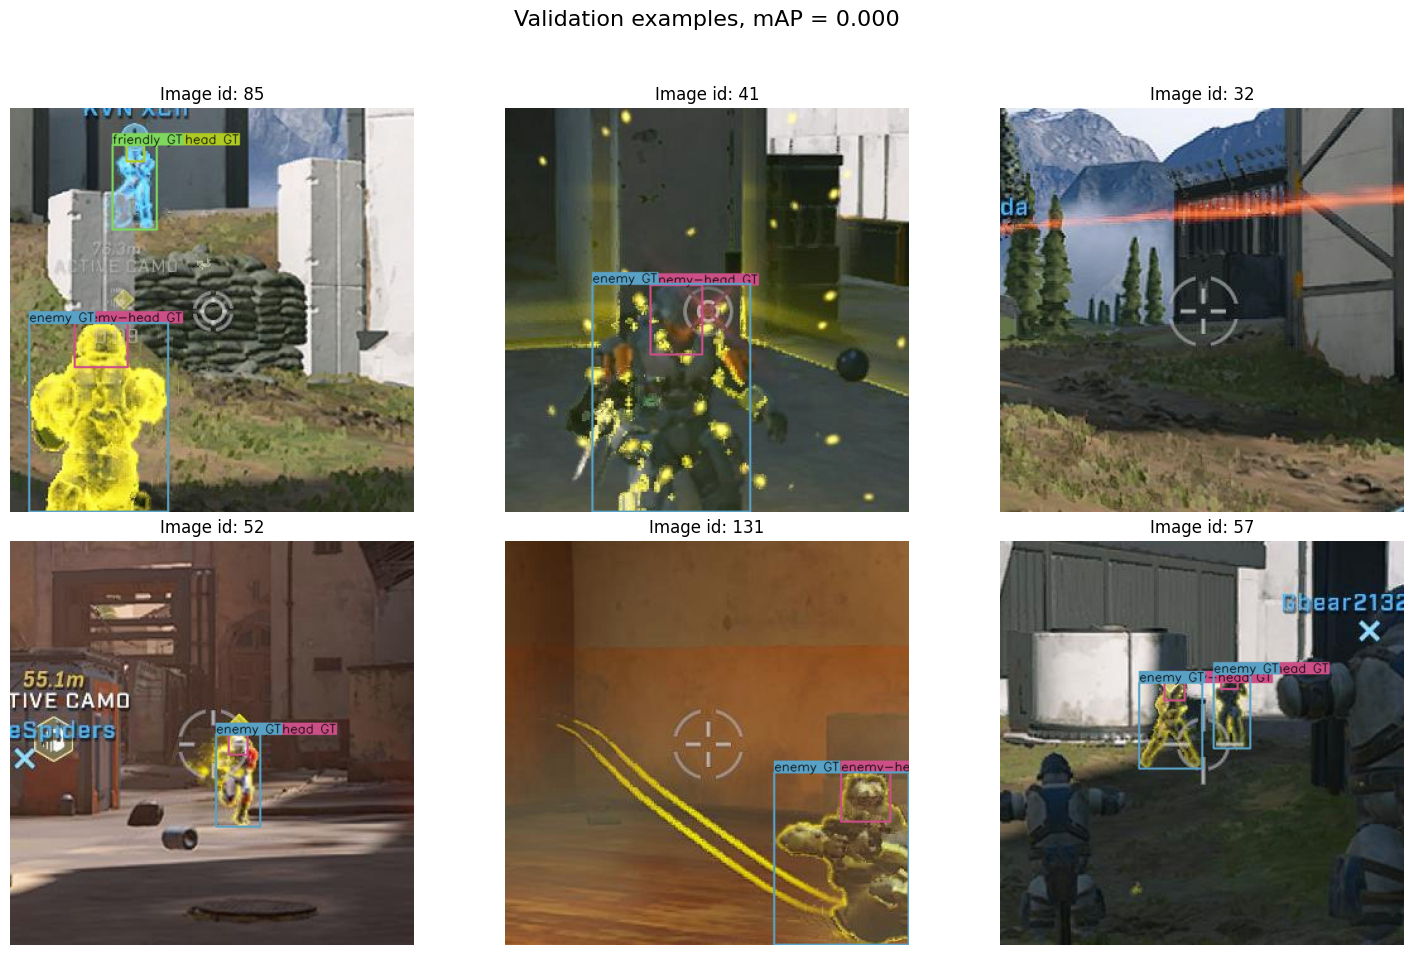

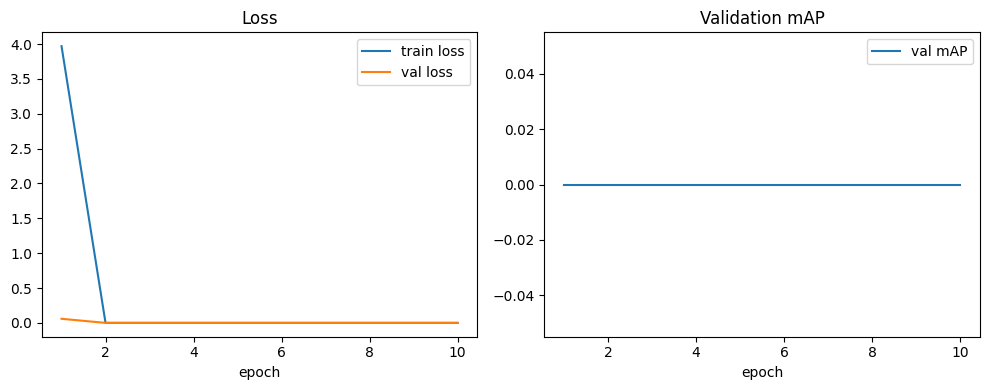

In [201]:
runner.train(num_epochs=num_epochs, plot_val=True)

In [205]:
torch.save(model.state_dict(), f'../models/detector_sd/10_epoch_0_map.pt')

**Примечание для проверяющих**: я вложила много времени в эту домашнюю работу и постаралась выполнить все задания. Однако модель не показала улучшения mAP несмотря на мои попытки. После трёх дней безуспешных исправлений я решила оставить работу в текущем виде и не тратить больше времени. **Спасибо за понимание!**

In [ ]:

# Место для обучения, валидации и экспериментов!


Ниже определена вспомогательная функция для валидации качества. Можете использовать `Runner.validate`. Важное уточнение, ей нужен метод для фильтрации предсказаний. Можете тоже скопировать его из семинара, если он у вас не менялся.

In [207]:
from torchmetrics.detection import MeanAveragePrecision

@torch.no_grad()
def validate(dataloader, filter_predictions_func, box_format="xyxy", device="cpu", score_threshold=0.1, nms_threshold=0.5, **kwargs):
    """ Метод для валидации модели.
    Возвращает mAP (0.5 ... 0.95).
    """
    self.model.eval()
    # Считаем метрику mAP с помощью функции из torchmetrics
    metric = MeanAveragePrecision(box_format=box_format, iou_type="bbox")
    for images, targets in tqdm(dataloader, desc="Running validation", leave=False):
        images = images.to(device)
        outputs = self.model(images)
        predicts = filter_predictions_func(outputs, score_threshold, nms_threshold, **kwargs)
        metric.update(predicts, targets)
    return metric.compute()["map"].item()
